In [19]:
'''
Using general variables WXYW where
W: G_abs, X:Halpha, Y:age, Z:color
'''
import numpy as np 
import scipy.optimize as op
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from sklearn import preprocessing
from matplotlib.colors import Normalize
#from fit_age_activity import *
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from corner import hist2d
%matplotlib notebook
#%config InlineBackend.figure_format = 'retina'

In [2]:
catalog = fits.open('Catalogs/FullSample.fits')

In [3]:
mask_ha = ((catalog[1].data['age'] < 14*1e3))

spt = catalog[1].data['spt']
g = catalog[1].data['g']
rp = catalog[1].data['rp']
bp = catalog[1].data['bp']
g_rp = g-rp
parallax = catalog[1].data['parallax']
parallax_error = catalog[1].data['parallax_error']
g_abs = g - 5*(np.log10(1e3/parallax)-1)
ewha = catalog[1].data['ewha']
log10ewha = np.log10(ewha)
ewha_error = catalog[1].data['ewha_error']
mask_nan = np.isnan(ewha_error)
ewha_error[mask_nan] = 0.2
log10ewha_error_up = np.log10(ewha + ewha_error) - log10ewha
log10ewha_error_down = log10ewha - np.log10(ewha - ewha_error)
log10ewha_error = log10ewha_error_up
#lhalbol = np.concatenate((catalog[1].data['lhalbol']
#lhalbol_error = np.concatenate((catalog[1].data['lhalbol_error']
age = catalog[1].data['age']
log10age = np.log10(age)
group_num = catalog[1].data['group_num']

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


In [4]:
g_rp_all = catalog[1].data['g'] - catalog[1].data['rp']
g_rp_all[len(g_rp_all)-3],g_rp_all[len(g_rp_all)-2],g_rp_all[len(g_rp_all)-1] = 0.93,1.01,1.09
g_abs_all = catalog[1].data['g'] - 5*(np.log10(1e3/catalog[1].data['parallax'])-1)
g_abs_all[len(g_abs_all)-3],g_abs_all[len(g_abs_all)-2],g_abs_all[len(g_abs_all)-1] = 8.13,8.78,9.35
age_all = catalog[1].data['age']

In [53]:
color_bin

array([0.614865, 1.039582, 1.464299, 1.889016])

In [188]:
Nbin_age = 10
color_bin = np.array([0.8,1.12,1.43,1.7])
abs_bin = np.array([8,9.6,13.2,17.11])
Nbin_color = len(color_bin)
age_bin = np.linspace(min(log10age[~np.isinf(log10age)]),max(log10age[~np.isinf(log10age)]),Nbin_age)

medians_age = []
medians_color = []
medians_abs = []
medians_median_ha = []
medians_uperr_ha = []
medians_downerr_ha = []
nbins = []


for i in range(Nbin-1):
    mask_color = (color_bin[i] <= g_rp_all) * (g_rp_all < color_bin[i+1])
    color_i = color_bin[i] + (color_bin[i+1] - color_bin[i])/2
    abs_i = abs_bin[i] + (abs_bin[i+1] - abs_bin[i])/2
    for j in range(Nbin_age-1):
        mask_age = (age_bin[j] <= log10age) * (log10age < age_bin[j+1])
        age_i = age_bin[j] + (age_bin[j+1] - age_bin[j])/2
        medians_color.append(color_i)
        medians_abs.append(abs_i)
        medians_age.append(age_i)
        if(any(mask_age*mask_color)):
            median_j = np.percentile(log10ewha[mask_age*mask_color],50)
            up_err_j = np.percentile(log10ewha[mask_age*mask_color],84) - median_j
            down_err_j = median_j - np.percentile(log10ewha[mask_age*mask_color],16)
            medians_median_ha.append(median_j)
            medians_uperr_ha.append(up_err_j)
            medians_downerr_ha.append(down_err_j)
            nbins.append(len(log10ewha[mask_age*mask_color]))
        else:
            medians_median_ha.append(np.nan)
            medians_uperr_ha.append(np.nan)
            medians_downerr_ha.append(np.nan)
            nbins.append(np.nan)
            
medians_age = np.array(medians_age)
medians_color = np.array(medians_color)
medians_abs = np.array(medians_abs)
medians_median_ha = np.array(medians_median_ha)
medians_uperr_ha = np.array(medians_uperr_ha)
medians_downerr_ha = np.array(medians_downerr_ha)
medians_err_ha = np.array([max([medians_uperr_ha[i],medians_downerr_ha[i]]) for i in range(len(medians_downerr_ha))])
nbins = np.array(nbins)

In [189]:
def fit_halpha(params,z,x,w):
    #a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12 = params
    a0,a1,a2,a3,a4,a5,a6,a7,a8,a9 = params
    #a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14 = params
    
    halpha_model = (a0 + a1*z + a2*z**2 +
                    a3*x + a4*x**2 +
                    a5*w + a6*w**2 + 
                    a7*z*x + a8*z*w + a9*x*w)
    
    #halpha_model = (a0/(a1*x**2-a2 +a3*z) + a5)
    #(a0 + a1/z + a2*z + a3*z**2 + 
    #                a4*x + a5*x**2 + 
    #                a6*w + a7*w**2 +  
    #                a8*z*x + a9*z*w + a10*x*w)
    #halpha_model = ((a0*x + a1*x**2 + a2*w + a3*w**2 + a4)/(z**2 - (a5*x + a6*x**2 + a7*w + a8*w**2 + a9)) +    
    #                a10*x + a11*x**2 + a12*w + a13*w**2 + a14)
    return halpha_model
        

def lnlike_color_abs_age(params_x,g_rp_x,log10age_x,g_abs_x,log10ewha_x,log10ewha_error_x):
    model_halpha = fit_halpha(params_x,g_rp_x,log10age_x,g_abs_x)
    return -0.5*np.sum((model_halpha - log10ewha_x)**2/(log10ewha_error_x**2)) 


In [190]:
mask_nan_inf = (~np.isnan(medians_age+medians_color+medians_abs+medians_median_ha+medians_err_ha)
                * (medians_err_ha!=0) * (medians_color < 1.4))

ini_params = np.ones(10)*0.1

nll = lambda *args: -lnlike_color_abs_age(*args)
res_all = op.minimize(nll, ini_params, args=(medians_color[mask_nan_inf],medians_age[mask_nan_inf],
                                             medians_abs[mask_nan_inf],medians_median_ha[mask_nan_inf],
                                             medians_err_ha[mask_nan_inf]))

In [191]:
res_all.x

array([ 0.23383215,  0.16674135,  0.08535002, -0.9271544 , -0.06806317,
        0.76623374, -0.09811564,  0.23102871,  0.03456191,  0.14478535])

In [192]:
age_x = np.linspace(6.4,9.6,20)
vmin,vmax=min(medians_color),max(medians_color)
cmap1 = cm.plasma
norm1 = Normalize(vmin=vmin, vmax=vmax)

<IPython.core.display.Javascript object>


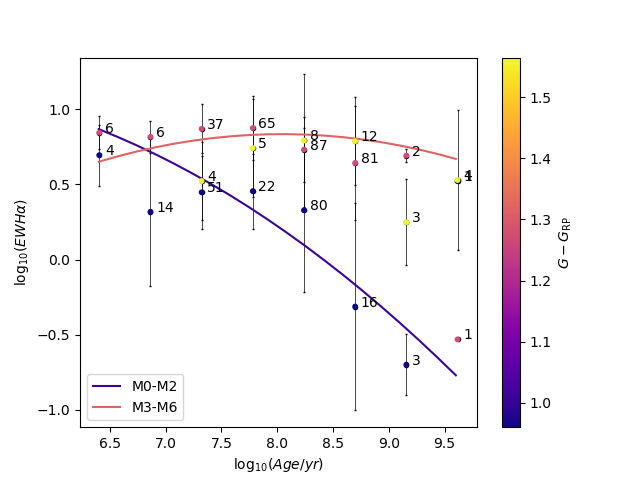

Text(0, 0.5, '$\\log _{10}(EWH\\alpha)$')

In [193]:
plt.errorbar(medians_age,medians_median_ha,yerr=medians_err_ha,fmt='k.',elinewidth=0.5,capsize=1)
plt.scatter(medians_age,medians_median_ha,c=medians_color,s=10,zorder=5,cmap='plasma',vmin=vmin,vmax=vmax)
plt.plot(age_x,fit_halpha(res_all.x,1.01,age_x,8.78),color = cmap1(norm1(1.01)),label='M0-M2')
plt.plot(age_x,fit_halpha(res_all.x,1.32,age_x,11.86),color = cmap1(norm1(1.32)),label='M3-M6')
for x,y,z in zip(medians_age,medians_median_ha,nbins):
    plt.text(x+0.05,y,'{0:.0f}'.format(z))
plt.legend()
plt.colorbar(label=r'$G-G_{\rm RP}$')
plt.xlabel(r'$\log _{10}(Age/yr)$')
plt.ylabel(r'$\log _{10}(EWH\alpha)$')